In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [14]:
#change these variables
data_path = r"/home/znjs2/input_data/atom_data_02_20/processed/all_atom_co_data_datetime.csv"
var_name = ['CO_PECD']
outfile = '/shared/netscratch/znjs2/atom_data_02_20/co_lat_binned_jf_3.npy'
#months wanted, change integers to select:
month_a = 'ch4_1'
month_b = 'ch4_2'

In [3]:
#read in data
ch4_data = pd.read_csv(data_path, delimiter=',', 
                        na_values = [-99999, -9999, -999, -888], 
                        parse_dates=[0], 
                        index_col=0)

#Get rid of NA vals
ch4_data = ch4_data.dropna(subset=var_name)
print(ch4_data.shape)

(6734, 5)


In [4]:
#bin by latitude
ch4_data['lat_bins'] = pd.cut(ch4_data.iloc[:,0],[-90,-60,-30,0,30,60,90], 
                              labels=list(range(6)))

## Separate by month, group into seasons etc

In [15]:
#check which months present
months_present, counts = np.unique(pd.DatetimeIndex(ch4_data.index).month, return_counts=True)
print(np.asarray((months_present, counts)).T)

[[   1  371]
 [   2 1290]
 [   4  525]
 [   5 1679]
 [   8 1145]
 [   9  178]
 [  10 1546]]


In [16]:
#make separate data frame for each month
monthly_ch4 = {}
for x in range(len(months_present)):
        monthly_ch4[f'ch4_{months_present[x]}'] = ch4_data[pd.DatetimeIndex(ch4_data.index).month == 
                                                           months_present[x]]

In [17]:
#bin data by season
ch4_jf = pd.concat((monthly_ch4.get(month_a),monthly_ch4.get(month_b)))

In [18]:
print(ch4_jf[:3])

                        G_LAT     G_LONG   G_ALT  CO_PECD  COe_PECD lat_bins
UTC_Start_dt                                                                
2017-01-26 17:15:29  34.69715 -118.03170  1677.5    122.5       9.9        4
2017-01-26 17:20:09  34.36746 -118.12504  3914.6    126.3       9.9        4
2017-01-26 17:22:29  34.17046 -118.18395  4741.8    125.6       9.9        4


## Bin by latitude

In [19]:
#how many data points in each lat bin?
lat_bins, counts = np.unique(ch4_jf.loc[:,'lat_bins'], return_counts=True)
print(np.asarray((lat_bins, counts)).T)

[[  0  94]
 [  1 243]
 [  2 210]
 [  3 404]
 [  4 394]
 [  5 316]]


In [20]:
#should define a function for this
lat_bands_obs_jf = np.empty((6,50))
base_obs_jf = np.zeros(6)

lat_band_grouped = {}
order = [3,3,3,3,3,3]
#order = [2,5,3,5,6,4] #change this value to change polyfit order
#order = [5,5,2,5,5,5] #order of np polyfit, methane JF
yvals = np.linspace(0,12000)

for i in range(6):
    #select data by latitude band
    lat_band = ch4_jf.loc[ch4_jf['lat_bins'] == i].iloc[:,[0,2,3]].dropna()
    lat_band_grouped[f'lat_{i}'] = lat_band #separate all data into dict of lat bands
    #generate coefficients and make function
    coefs = np.polyfit(lat_band.iloc[:,1],lat_band.iloc[:,2],order[i])
    fit = np.poly1d(coefs)
    base_obs_jf[i] = fit(0) #set zero value
    lat_bands_obs_jf[i] = fit(yvals)
    
print(lat_bands_obs_jf.shape)
np.save(outfile, lat_bands_obs_jf)

(6, 50)


## Visualise data

Text(0.5, 1.0, '0, order = 2')

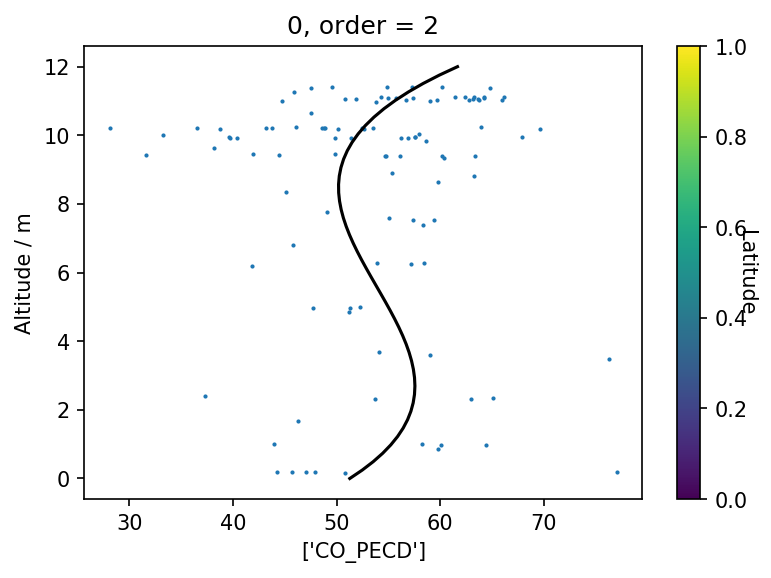

In [11]:
fig = plt.figure(dpi=150)
ax = plt.axes()

data_frame = lat_band_grouped.get('lat_0')

plot = ax.scatter(data_frame.iloc[:,2],data_frame.iloc[:,1]/1000,s=1)

ax.plot(lat_bands_obs_jf[0,:], yvals/1000, c='k')

cbar = plt.colorbar(plot)
cbar.set_label('Latitude', rotation=270)
#ax.set_xlim(0,200)
plt.xlabel(f'{var_name}')
plt.ylabel('Altitude / m')
plt.title(f'0, order = 2')

Text(0, 0.5, 'Altitude / m')

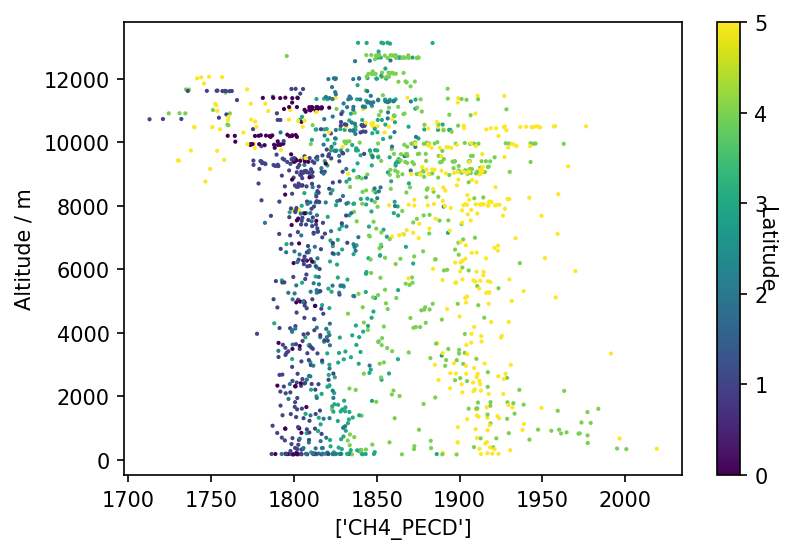

In [244]:
fig = plt.figure(dpi=150)
ax = plt.axes()
plot = ax.scatter(ch4_jf.iloc[:,3],ch4_jf.iloc[:,2],s=1, c=ch4_jf.loc[:,'lat_bins'])

cbar = plt.colorbar(plot)
cbar.set_label('Latitude', rotation=270)
#ax.set_xlim(0,200)
plt.xlabel(f'{var_name}')
plt.ylabel('Altitude / m')
#plt.title(f'CH4 Profile')

Text(0.5, 1.0, 'CH4 Profile: model with emissions (xltln) JA')

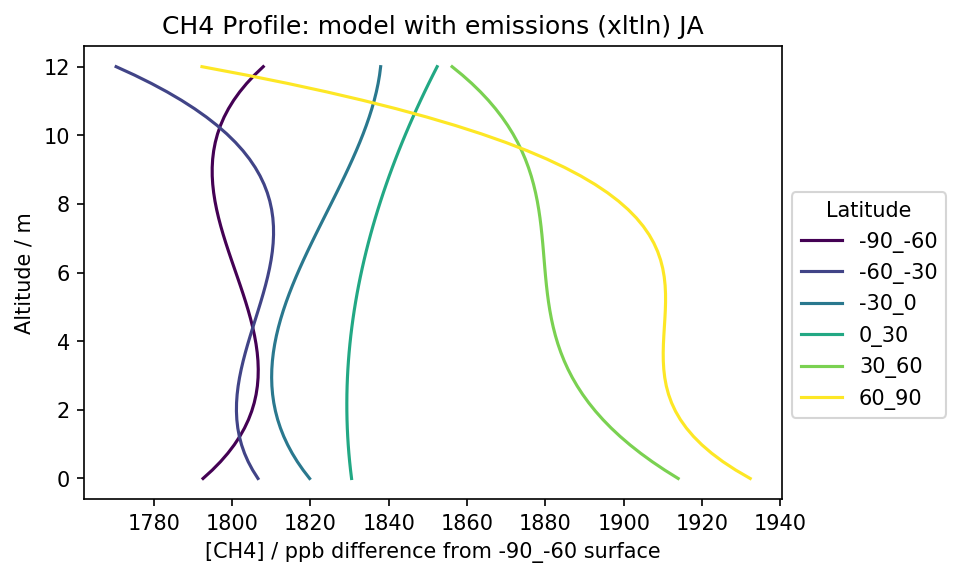

In [245]:
#removed - base obs, needed for methane
fig = plt.figure(dpi=150)
ax = plt.axes()
cmap = matplotlib.cm.get_cmap('viridis')

plt_labels=["-90_-60","-60_-30","-30_0","0_30","30_60","60_90"]

#ax.scatter(ch4_jf.iloc[:,3],ch4_jf.iloc[:,2]/1000,s=1, c=ch4_jf.loc[:,'lat_bins'])

for i in range(6):
    #ax.plot(lat_mean - base[0], alt, label=f'{i} to {i+30}',c=cmap((i+90)/150))
    ax.plot(lat_bands_obs_jf[i,:], yvals/1000, c=cmap(i/5) ,label=f'{plt_labels[i]}')
    
plt.legend(title='Latitude',bbox_to_anchor=(1.25,0.7))
#ax.set_ylim(0,12000)
#ax.set_xlim(0,250)
plt.xlabel('[CH4] / ppb difference from -90_-60 surface')
plt.ylabel('Altitude / m')
plt.title(f'CH4 Profile: model with emissions (xltln) JA')

Text(0.5, 1.0, 'CH4')

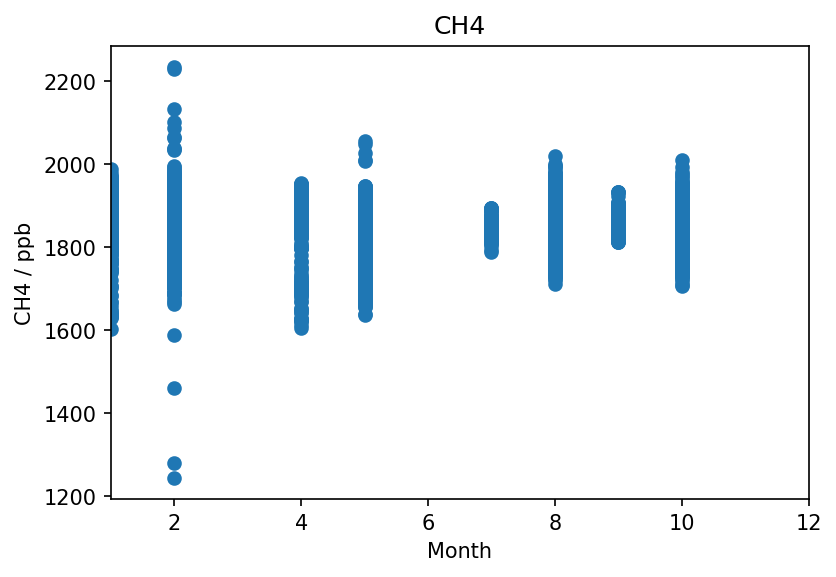

In [229]:
fig = plt.figure(dpi=150)
ax = plt.axes()
ax.scatter(pd.DatetimeIndex(ch4_data.index).month,ch4_data.iloc[:,3])
ax.set_xlim(1,12)
plt.xlabel('Month')
plt.ylabel('CH4 / ppb')
plt.title(f'CH4')